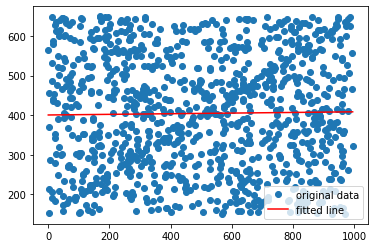

In [51]:
import random
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import cv2
import itertools


def value(alpha = 0.95):
    x = 1000 * random.random()
    y = 0.5 * x + random.gauss(0, 3) + 150
    if random.random() < alpha:
        y = random.uniform(150, 650)
    return x, y


values = [value() for _ in range(1000)]
values.sort()

x = np.array([v[0] for v in values])
y = np.array([v[1] for v in values])
res = stats.linregress(x, y)
plt.plot(x, y, 'o', label='original data')
plt.plot(x, res.intercept + res.slope*x, 'r', label='fitted line')
plt.legend()

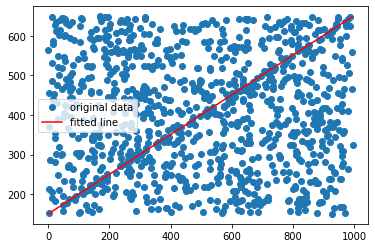

In [52]:
def fit_model(data):
    x = np.array([v[0] for v in data])
    y = np.array([v[1] for v in data])
    return stats.linregress(x, y)

def ransac(data, n_epochs=2000, threshold=15, inliers_min = 30):
    best_n_inliers = 0
    best_model = None
    for _ in range(n_epochs):
        sample = random.sample(data, 2)
        model = fit_model(sample)

        for s in data:
            if s in sample:
                continue

            err = (s[0]*model.slope + model.intercept - s[1]) ** 2
            if err <= threshold:
                sample.append(s)

        n_inliers = len(sample)
        if n_inliers < inliers_min:
            continue

        if best_n_inliers < n_inliers:
            best_model = fit_model(sample)
            best_n_inliers = n_inliers

    return best_model

res = ransac(values)
plt.plot(x, y, 'o', label='original data')
plt.plot(x, res.intercept + res.slope*x, 'r', label='fitted line')
plt.legend()

In [55]:
def mark_corners(photo, withNoise = False):
    retval, corners = cv2.findChessboardCorners(photo, (8, 5))
    if retval:
        corners = cv2.cornerSubPix(cv2.cvtColor(photo, cv2.COLOR_BGR2GRAY), corners, (11, 11), (-1, -1),
                                   (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))
        
        if withNoise:
            for i in range(30, 35):
                corners[i,0,0] += random.randint(-10, 10)
                corners[i,0,1] += random.randint(-10, 10)
            for i in range(35, 40):
                corners[i,0,0] = random.randint(0, 800)
                corners[i,0,1] = random.randint(0, 600)
            
        photo = cv2.drawChessboardCorners(photo, (8, 5), corners, retval)
        return corners
    else:
        print("Couldn't find a chessboard in given photo")
        return None


def get_objpoints(width, size):
    prod = itertools.product(range(size[1]), range(size[0]))
    prod = (p[::-1] for p in prod)
    objpoints = np.array([[p1, p2, 0.0] for p1, p2 in prod], np.float32) * width
    return objpoints


def show_photo(photo):
    cv2.imshow('a', photo)
    cv2.waitKey(10000)
    cv2.destroyAllWindows()


def coordinates(point):
    return [int (i) for i in tuple(point.ravel())]


def draw(img, corners, imgpts):
    corner = coordinates(corners[0].ravel())
    img = cv2.line(img, corner, coordinates(imgpts[0]), (255,0,0), 5)
    img = cv2.line(img, corner, coordinates(imgpts[1]), (0,255,0), 5)
    img = cv2.line(img, corner, coordinates(imgpts[2]), (0,0,255), 5)
    return img


def get_axes_ends(rvec, tvec, cameraMatrix, distCoeffs):
    x_axe_end = cv2.projectPoints(np.array([(100.0, 0.0, 0.0)]), rvec, tvec, cameraMatrix, distCoeffs)[0][0]
    y_axe_end = cv2.projectPoints(np.array([(0.0, 100.0, 0.0)]), rvec, tvec, cameraMatrix, distCoeffs)[0][0]
    z_axe_end = cv2.projectPoints(np.array([(0.0, 0.0, -100.0)]), rvec, tvec, cameraMatrix, distCoeffs)[0][0]
    
    return x_axe_end, y_axe_end, z_axe_end
    

cameraMatrix = np.load('../lab8/camera_calibration_data/cameraMatrix.npy')
distCoeffs = np.load('../lab8/camera_calibration_data/distCoeffs.npy')

In [56]:
img = cv2.imread('./images/photo8.png')
show_photo(img)

imgpoints = [mark_corners(img)]
objpoints = [get_objpoints(30, (8, 5))] * len(imgpoints)

_, rvec, tvec = cv2.solvePnP(objpoints[0], imgpoints[0], cameraMatrix, distCoeffs)
x_axe_end, y_axe_end, z_axe_end = get_axes_ends(rvec, tvec, cameraMatrix, distCoeffs)

img_copy = img.copy()
img_copy = draw(img_copy, imgpoints[0], np.stack([x_axe_end, y_axe_end, z_axe_end]))
show_photo(img_copy)

In [57]:
img = cv2.imread('./images/photo8.png')
show_photo(img)

imgpoints = [mark_corners(img, True)]
objpoints = [get_objpoints(30, (8, 5))] * len(imgpoints)

_, rvec, tvec = cv2.solvePnP(objpoints[0], imgpoints[0], cameraMatrix, distCoeffs)
x_axe_end, y_axe_end, z_axe_end = get_axes_ends(rvec, tvec, cameraMatrix, distCoeffs)

img_copy = img.copy()
img_copy = draw(img_copy, imgpoints[0], np.stack([x_axe_end, y_axe_end, z_axe_end]))
show_photo(img_copy)

In [64]:
img = cv2.imread('./images/photo8.png')
show_photo(img)

imgpoints = [mark_corners(img, True)]
imgpoints = np.array(imgpoints)
imgpoints = imgpoints.reshape(-1, 2)

objpoints = [get_objpoints(30, (8, 5))] * len(imgpoints)
objpoints = np.array(objpoints)
objpoints = objpoints.reshape(-1, 3)

best_n_inliers = 0
best_rvec = None
best_tvec = None
for _ in range(1000):
    indx =  random.sample(range(40), k=6)
    sample_imgpoints = imgpoints[indx]
    sample_objpoints = objpoints[indx]
    
    _, rvec, tvec = cv2.solvePnP(sample_objpoints, sample_imgpoints, cameraMatrix, distCoeffs)
    
    for point2d, point3d in zip(imgpoints, objpoints):
        if point2d in sample_imgpoints:
            continue
            
        pred = cv2.projectPoints(point3d, rvec, tvec, cameraMatrix, distCoeffs)[0][0]
        if np.linalg.norm(pred - point2d) <= 10:
            sample_imgpoints = np.append(sample_imgpoints, [point2d], axis=0)
            sample_objpoints = np.append(sample_objpoints, [point3d], axis=0)
    
    n_inliers = len(sample_imgpoints)
    if n_inliers < 30:
        continue

    if best_n_inliers < n_inliers:
        _, best_rvec, best_tvec = cv2.solvePnP(sample_objpoints, sample_imgpoints, cameraMatrix, distCoeffs)
        best_n_inliers = n_inliers

x_axe_end, y_axe_end, z_axe_end = get_axes_ends(best_rvec, best_tvec, cameraMatrix, distCoeffs)

img_copy = img.copy()
img_copy = draw(img_copy, imgpoints, np.stack([x_axe_end, y_axe_end, z_axe_end]))
show_photo(img_copy)

In [65]:
img = cv2.imread('./images/photo8.png')
show_photo(img)

imgpoints = [mark_corners(img, True)]
objpoints = [get_objpoints(30, (8, 5))] * len(imgpoints)

_, rvec, tvec, _ = cv2.solvePnPRansac(objpoints[0], imgpoints[0], cameraMatrix, distCoeffs)
x_axe_end, y_axe_end, z_axe_end = get_axes_ends(rvec, tvec, cameraMatrix, distCoeffs)

img_copy = img.copy()
img_copy = draw(img_copy, imgpoints[0], np.stack([x_axe_end, y_axe_end, z_axe_end]))
show_photo(img_copy)